Tomasz Szoldra homework

Modifications: 

using imageio library instead of scipy to save images (deprecated scipy.misc.imsave() function);

in inception_v1_linear.py: changed 
from keras.applications.imagenet_utils import _obtain_input_shape
into
from keras_applications.imagenet_utils import _obtain_input_shape
;

changed filter/class to 350 (bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis)

# Interpretability I: Feature Visualization

## Copyright notice

Parts of this code are adapted from https://pastebin.com/ETXc7Xma and the [Keras example](https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py), (c) 2015 - 2018, François Chollet, [MIT License](https://github.com/keras-team/keras/blob/master/LICENSE). This version (c) 2018 Fabian Offert, [MIT License](LICENSE).

## Background

Feature visualization has been an important area of research within machine learning in general and deep learning in particular at least since 2014 [Zeiler 2014, Simonyan 2014]. "Deep Dream", for instance, works by applying feature visualization techniques to images, albeit optimized for producing the kind of visuals it has become famous for. Since then, particularly with the invention of GANs, more elaborate methods have emerged that employ natural image priors to "bias" visualizations towards more "legible" images [Dosovitskiy 2016, Nguyen 2016a, Nguyen 206b, Nguyen 2017]. Recently, feature visualization and related methods have received a lot of attention as possible solutions to the problem of interpretability, most prominently in [Olah 2017, Olah 2018]. Nevertheless, almost all visualization methods rely on the principle of activation maximization. They visualize the learned features of a particular neuron/channel/layer by optimizing an input image to maximally activate this neuron/channel/layer. 

Below, we visualize the features of selected channels from the InceptionV1 (also known as GoogLeNet) network, trained on ImageNet. As [Olah 2018] point out, this particular network seems to produce much more legible visualizations then comparable (newer) networks, even without supplying natural image priors.

## Imports

We are importing almost the same libraries as in the ["Deep Dreaming" notebook](2-deepdream.ipynb), except for two filter functions from SciPy, and two libraries to interface with the operating system. We need these later to run ImageMagick on our images to produce a nice montage.

In [0]:
import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
from scipy.ndimage.filters import gaussian_filter, median_filter
from keras import backend as K
from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display
from subprocess import call
import os
import imageio

## Settings

We use InceptionV1 as our model. As this architecture does not ship with Keras, we utilize [this custom implementation](https://github.com/fchollet/deep-learning-models/pull/59), with some minor changes/fixes. Most importantly, we change the softmax activation function into a linear activation function, as suggested in [Simonyan 2014].

In [4]:
# We are in the "test" phase, not the "training" phase, w.r.t. to the model we are analyzing
K.set_learning_phase(0)

# Load model with ImageNet pre-trained weights
# Source: https://github.com/fchollet/deep-learning-models/pull/59
import inception_v1_linear
model = inception_v1_linear.InceptionV1(weights='imagenet', include_top=True) 
model.summary()












26968064/26962860 [==============================] - 9s 0us/step
Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_7x7_conv (Conv2D)     (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_7x7_bn (BatchNormaliz (None, 112, 112, 64) 192         Conv2d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv2d_1a_7x7_act (Activation)  (None, 112, 112, 64) 0           Conv2d_1a_7x7_bn[0][0]           
___________

We also define two sets of settings: one for visualizing the classes of the model (`settings_InceptionV1_classes`), and one for visualizing arbitrary layers of the model (`settings_InceptionV1_single`). Other than with V3, for InceptionV1 the input size is fixed to $224^2$ pixels.

In [0]:
settings_InceptionV1_classes = ['Predictions']
settings_InceptionV1_single = ['Mixed_4b_Concatenated']
settings = settings_InceptionV1_classes
size = 224 # 224 for InceptionV1, variable for InceptionV3

Finally, we define which part of the layer we would like to visualize: just one particular channel (e.g. `filters = [8]` would look at the "hen" class in the `Predictions` layer), all available channels (`filters = None; sum_filters = False`), or the sum of all available channels (`filters = None; sum_filters = True`). If we are analyzing the output layer, the classes are defined according to [this list](https://github.com/happynear/caffe-windows/blob/master/examples/GoogLeNet/synset_words.txt).

In [0]:
filters = [350, 350, 350, 350] # If None use all available filters (don't use None for prediction layers, define range!)
sum_filters = False # If true, sum all filters, if false iterate over all filters

## Image preprocessing and deprocessing

We are using the same image helper functions as in the ["Deep Dreaming" notebook](3-deepdream.ipynb).

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0) # Add extra dimension for mini batches (not used)
    img = inception_v1_linear.preprocess_input(img) # 3D -> 1D
    return img

def deprocess_image(x):
    # Check ~/.keras/keras.json to make sure "image_data_format" is set to "channels_last"
    # or print(K.image_data_format())
    x = x.reshape((x.shape[1], x.shape[2], 3)) # "Remove" extra dimension, channels last
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8') # Clip to visible range
    x = autotone(x)
    return x

# Simple resize function based on scipy
def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

# Simple save function based on scipy
def save_image(img, fname):
    pil_img = deprocess_image(np.copy(img))
    #scipy.misc.imsave(fname, pil_img)
    imageio.imwrite(fname, pil_img)
    
def show_image(img, fmt='jpeg'):
    img = deprocess_image(np.copy(img))
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))

## More image preprocessing and deprocessing 

In addition, we define two functions to save images sequences. The first one (`save_image_numbered`) simly creates numbered sequences, the second one (`save_image_sweep`) includes a dictionary into the filename. We use this second function ofr hyperparameter sweeps (see below).

In [0]:
def montage_images(folder, size):
    print('Montaging...')
    geometry = '-geometry "' + str(size) + 'x' + str(size) + '+2+2>" '
    label = '-label "%t" '
    output = folder + '/montage.jpg'
    infiles = folder + '/*.jpg '
    montage = 'montage  ' + label + infiles + geometry + output
    call(montage, shell=True)
    print('...done.')

def save_image_numbered(img, nr, folder):
    f = '{0:03d}'.format(nr)
    p = folder + '/' + f + '.jpg'
    save_image(img, p)
    
def save_image_sweep(img, filter, sweep, folder):
    # Concatenate the list of values in the dictionary as strings
    f = str(filter) + '_' + '_'.join(str(x) for x in list(sweep.values()))
    p = folder + '/' + f + '.jpg'
    print('Writing ' + p)
    save_image(img, p)

## Regularization

Regularization introduces priors into the loss function. By utilizing regularization, we end up with "better", more legible images. To start, we define a simple "auto tone" function (`autotone`) that normalizes each color channel in an image separately – exactly what Photoshop is doing in its "auto tone" function – to get more legible images. We also do not start with a plain gray image but with a gray image that includes some Gaussian white noise.

In [0]:
# Normalize each color sepearately (Photoshop auto tone)
def autotone(img):
    img[:,:,0] = np.interp(img[:,:,0], [np.amin(img[:,:,0]), np.amax(img[:,:,0])], [0, 255])
    img[:,:,1] = np.interp(img[:,:,1], [np.amin(img[:,:,1]), np.amax(img[:,:,1])], [0, 255])
    img[:,:,2] = np.interp(img[:,:,2], [np.amin(img[:,:,2]), np.amax(img[:,:,2])], [0, 255])
    return img

def gray_square(size, variance): 
    img = np.random.normal(0, variance, (1, size, size, 3))
    return img

Three other regularization functions are embedded into the gradient ascent function: a Gaussian blur function, and a median filter function. Their utilization is controlled by several hyperparameters that define how often these filters are applied (every four iterations, for instance) and how strong they are. By tuning these hyperparameters, either manually or automatically by means of hyperparameter sweeps (see below), we can find settings that subjectively produce better images, images that are more obviously representations of existing concepts. As so often, however, good is better then best, as the "best" images, i.e. the images that activate the layer/filter we are looking at the most, are usually just high-frequency noise. As pointed out by [Szegedy 2013], this link between adversarial examples and semantic is one of the most "intruiging properties" of neural networks that has [many interesting epistemological implications](https://arxiv.org/abs/1711.08042).

In [0]:
def gradient_ascent(x, 
                    iterations=1000, 
                    step=0.01, 
                    max_loss=None, 
                    blur_std=0, 
                    blur_every=8, 
                    median_fsize=5, 
                    median_every=4):
    
    for i in range(iterations):
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1]
        if max_loss is not None and loss_value > max_loss:
            break
        x += step * grad_values      
        
        if(i!=iterations-1): # No regularization on last iteration for good quality output 
            # Gaussian blur
            if blur_std is not 0 and i % blur_every == 0 :
                x = gaussian_filter(x, sigma=[0, blur_std, blur_std, 0])  
            # Median filter
            if median_fsize is not 0 and i % median_every == 0 :
                x = median_filter(x, size=(1, median_fsize, median_fsize, 1))
                
    return x

# Dictionary of the names of the layers and the layers themselves
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Input of the first layer, in the example: model.input
dream = model.layers[0].input 

# A TF variable (persistent)
loss = K.variable(0.)

## Hyperparameter Sweeping

To find the "right" hyperparameters for the regularization techniques that we have introduced, we create a "sweep" function that conveniently applies sets of pre-defined parameters in all possible permutations to the same class/filter.

In [34]:
# Sweep over all possible permutations of allowed hyperparameters in a very un-pythonic but simple way

"""
# Sweep InceptionV1
iterations = [2500]
steps = [0.01, 0.1]
max_losses = [None]
blur_stds = [0]
blur_everys = [2, 4, 8]
median_fsizes = [3, 5, 7]
median_everys = [2, 4, 8]
variances = [0.01, 1]
"""

# Best values InceptionV1 from sweep above
iterations = [1000]
steps = [0.01]
max_losses = [None]
blur_stds = [0]
blur_everys = [4]
median_fsizes = [5]
median_everys = [4]
variances = [0.01]

sweeps = []

for iteration in iterations:
    for step in steps:
        for max_loss in max_losses:
            for blur_std in blur_stds:
                for blur_every in blur_everys:
                    for median_fsize in median_fsizes:
                        for median_every in median_everys:
                            for variance in variances:
                                sweeps.append({'iterations':iteration,
                                                'step':step,
                                                'max_loss':max_loss,
                                                'blur_std':blur_std,
                                                'blur_every':blur_every,
                                                'median_fsize':median_fsize,
                                                'median_every':median_every,
                                                'variance':variance})
                                
print(str(len(sweeps)) + ' sweeps generated')

1 sweeps generated


# Activation maximiation

We now run the activation maximization process for the selected layers/channels. The process is exactly the same as in the ["Deep Dreaming" notebook](3-deepdream.ipynb), except for a simpler loss function if we are looking at classes, as the last layer already gives us a single scalar loss value.

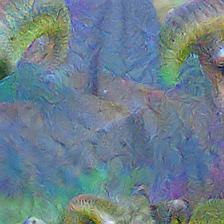

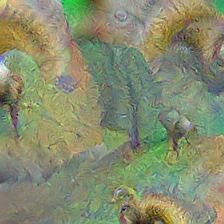

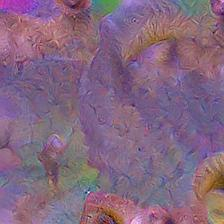

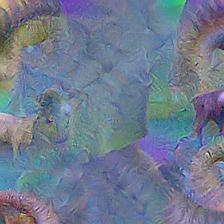

Montaging...
...done.


In [35]:
folder = '3-features/'

# Iterate only over the layers picked above and their available filters
for layer_name in settings: 
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.' # Layer in model?
    
    # Create directory to hold frames
    if not os.path.exists(folder + layer_name):
        os.makedirs(folder + layer_name)
    
    x = layer_dict[layer_name].output # Output of the current layer
        
    if (filters == None and not sum_filters): channels = list(range(x.shape[3])) # Iterate over all filters
    elif (filters == None and sum_filters): channels = [1] # Sum all filters
    else: channels = filters
    
    # We might want to stop early and not be stuck with the same filters every time
    np.random.shuffle(channels)
    
    for channel in channels:
        
        for sweep in sweeps:
    
            # We avoid border artifacts by only involving non-border pixels in the loss, offset by 2 on all sides
            if (filters == None and sum_filters): loss = K.sum(K.mean(x[:, 2: -2, 2: -2, :]))
            elif (filters == None and not sum_filters): loss = K.sum(K.mean(x[:, 2: -2, 2: -2, channel]))
            # Classification layers just give a single probability, so no sum/mean/offset
            else: loss = model.layers[-1].output[0, channel] # Always output of the last layer
    
            # Compute the gradients of the dream w.r.t. the loss.
            grads = K.gradients(loss, dream)[0]
            # Normalize gradients.
            grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

            fetch_loss_and_grads = K.function([dream], [loss, grads])

            img = gray_square(size, sweep['variance'])
            img = gradient_ascent(img, 
                                  iterations=sweep['iterations'], 
                                  step=sweep['step'], 
                                  max_loss=sweep['max_loss'],
                                  blur_std=sweep['blur_std'], 
                                  blur_every=sweep['blur_every'], 
                                  median_fsize=sweep['median_fsize'], 
                                  median_every=sweep['median_every'])
            if (len(sweeps) > 1): save_image_sweep(img, channel, sweep, '4-features/' + layer_name)
            else:
                show_image(img)
                save_image_numbered(img, channel, folder + layer_name)
        
    montage_images(layer_name, size)

## Results

### First 500 classes of InceptionV1 as per the hyperparameters defined above

[link text](https://)![](4-features/Predictions-500/montage.jpg)

#### Some notable (hand-picked) classes
Top to bottom: goldfish, Carassius auratus (2), loggerhead, loggerhead turtle, Caretta caretta (34), king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica (122), bee (310), bakery, bakeshop, bakehouse (416)


![](3-features/Predictions-500/002.jpg)
![](3-features/Predictions-500/034.jpg)  
![](3-features/Predictions-500/122.jpg)
![](3-features/Predictions-500/310.jpg)
![](3-features/Predictions-500/416.jpg)

### Random 100 filters of InceptionV1 layer Mixed_4c_Concatenated as per the hyperparameters defined above

![](3-features/4C-100R/montage.jpg)

### Random 100 filters of InceptionV1 layer Mixed_5b_Concatenated as per the hyperparameters defined above

![](3-features/5B-100R/montage.jpg)

## Bibliography

- Dosovitskiy, Alexey, and Thomas Brox. "Generating Images with Perceptual Similarity Metrics Based on Deep Networks." In Advances in Neural Information Processing Systems, 658–66, 2016. http://papers.nips.cc/paper/6157-generating- images-with-perceptual-similarity-metrics-based-on-deep-networks.
- Nguyen, Anh, Alexey Dosovitskiy, Jason Yosinski, Thomas Brox, and Jeff Clune. "Synthesizing the Preferred Inputs for Neurons in Neural Networks via Deep Generator Networks." In Advances in Neural Information Processing Systems,
3387–95, 2016. http://papers.nips.cc/paper/6519-synthesizing-the-preferred- inputs-for-neurons-in-neural-networks-via-deep-generator-networks.
- Nguyen, Anh, Jason Yosinski, Yoshua Bengio, Alexey Dosovitskiy, and Jeff Clune. "Plug & Play Generative Networks: Conditional Iterative Generation of Images in Latent Space." arXiv Preprint, 2017. https://arxiv.org/abs/1612.00005.
- Nguyen, Anh, Jason Yosinski, and Jeff Clune. "Multifaceted Feature Visualization: Uncovering the Different Types of Features Learned by Each Neuron in Deep Neural Networks." arXiv Preprint arXiv:1602.03616, 2016. https://arxiv.org/abs/1602.03616.
- Olah, Chris, Alexander Mordvintsev, and Ludwig Schubert. "Feature Visualization." Distill, 2017. https://distill.pub/2017/feature-visualization.
- Olah, Chris, Arvind Satyanarayan, Ian Johnson, Shan Carter, Ludwig Schubert, Katherine Ye, and Alexander Mordvintsev. "The Building Blocks of Interpretability." Distill, 2018. https://distill.pub/2018/building-blocks/
- Simonyan, Karen, Andrea Vedaldi, and Andrew Zisserman. "Deep inside convolutional networks: Visualising image classification models and saliency maps." arXiv preprint arXiv:1312.6034, 2013. https://arxiv.org/abs/1312.6034
- Szegedy, Christian, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, and Rob Fergus. "Intriguing Properties of Neural Networks." arXiv Preprint arXiv:1312.6199, 2013. https://arxiv.org/abs/1312.6199